In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import zscore
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

## Scatterplot of raw moments/dadi against simulated params

In [ ]:
import os
import glob
import pickle
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

directory = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
file_pattern = os.path.join(directory, "software_inferences_sim_*.pkl")

# Parameters to analyze (excluding "m")
parameters = ["Na", "N1", "N2", "t_split"]

def process_file(filepath):
    # Worker function: Load file and pick best inference based on max ll
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    dadi_results = sim_data['opt_params_dadi']
    moments_results = sim_data['opt_params_moments']
    simulated_params = sim_data['simulated_params']

    # Pick the dadi inference result with the highest ll
    best_dadi = max(dadi_results, key=lambda d: d['ll'])
    # Pick the moments inference result with the highest ll
    best_moments = max(moments_results, key=lambda d: d['ll'])

    return filepath, simulated_params, best_dadi, best_moments

# Get all files
files = glob.glob(file_pattern)

# Parallel processing
n_proc = 8  # Adjust based on available cores
with multiprocessing.Pool(n_proc) as pool:
    results = pool.map(process_file, files)

# Extract data for plotting
sim_truths = {param: [] for param in parameters}
dadi_avgs = {param: [] for param in parameters}
moments_avgs = {param: [] for param in parameters}
file_paths = {param: [] for param in parameters}
outlier_indices = {param: [] for param in parameters}

for file_path, sim_params, best_dadi, best_moments in results:
    for param in parameters:
        sim_truths[param].append(sim_params[param])
        dadi_avgs[param].append(best_dadi[param])
        moments_avgs[param].append(best_moments[param])
        file_paths[param].append(file_path)

# Convert lists to numpy arrays
for param in parameters:
    sim_truths[param] = np.array(sim_truths[param])
    dadi_avgs[param] = np.array(dadi_avgs[param])
    moments_avgs[param] = np.array(moments_avgs[param])
    file_paths[param] = np.array(file_paths[param])

    
    q1 = np.percentile(moments_avgs[param], 25)
    q3 = np.percentile(moments_avgs[param], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = (moments_avgs[param] >= lower_bound) & (moments_avgs[param] <= upper_bound)
    
    # # Compute z-scores for moments_avgs (as an example)
    # z_moments = zscore(moments_avgs[param])
    # # Define mask (True = keep, False = outlier)
    # mask = np.abs(z_moments) < 3

    # Identify outlier indices before masking
    outlier_idx = np.where(~mask)[0]
    if len(outlier_idx) > 0:
        print(f"Outliers detected for parameter '{param}':")
        for idx in outlier_idx:
            print(f"  File: {file_paths[param][idx]}")
            print(f"  Index: {idx}, SimTruth: {sim_truths[param][idx]}, "
                  f"Dadi: {dadi_avgs[param][idx]}, Moments: {moments_avgs[param][idx]}")

    # Now apply the mask
    sim_truths[param] = sim_truths[param][mask]
    dadi_avgs[param] = dadi_avgs[param][mask]
    moments_avgs[param] = moments_avgs[param][mask]
    file_paths[param] = file_paths[param][mask]
    outlier_indices[param] = outlier_idx

# After this, you can proceed to create scatterplots or other visualizations as before.


Outliers detected for parameter 'N1':
  File: /sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_1111.pkl
  Index: 124, SimTruth: 26119, Dadi: 24489.03036461252, Moments: 2.155961968251828e+35
  File: /sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_1413.pkl
  Index: 459, SimTruth: 29255, Dadi: 28696.000077445984, Moments: 1.7638528897481187e+35
  File: /sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_1716.pkl
  Index: 795, SimTruth: 29668, Dadi: 28034.081992163843, Moments: 4.14739031959107e+30
  File: /sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_294.pkl
  Index: 2165, SimTruth: 21089, Dadi: 21648.712736986305, Moments: 5.098130378789126e+33
  File: /sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_3252.pkl
  Index: 2502, SimTruth: 24007, Dadi: 20278.56921544464, Moments: 

In [32]:
outlier_indices

{'Na': array([], dtype=int64),
 'N1': array([ 124,  459,  795, 2165, 2502]),
 'N2': array([ 828, 1614, 1799, 2183, 2514, 2596, 2856, 2884]),
 't_split': array([1680, 4551])}

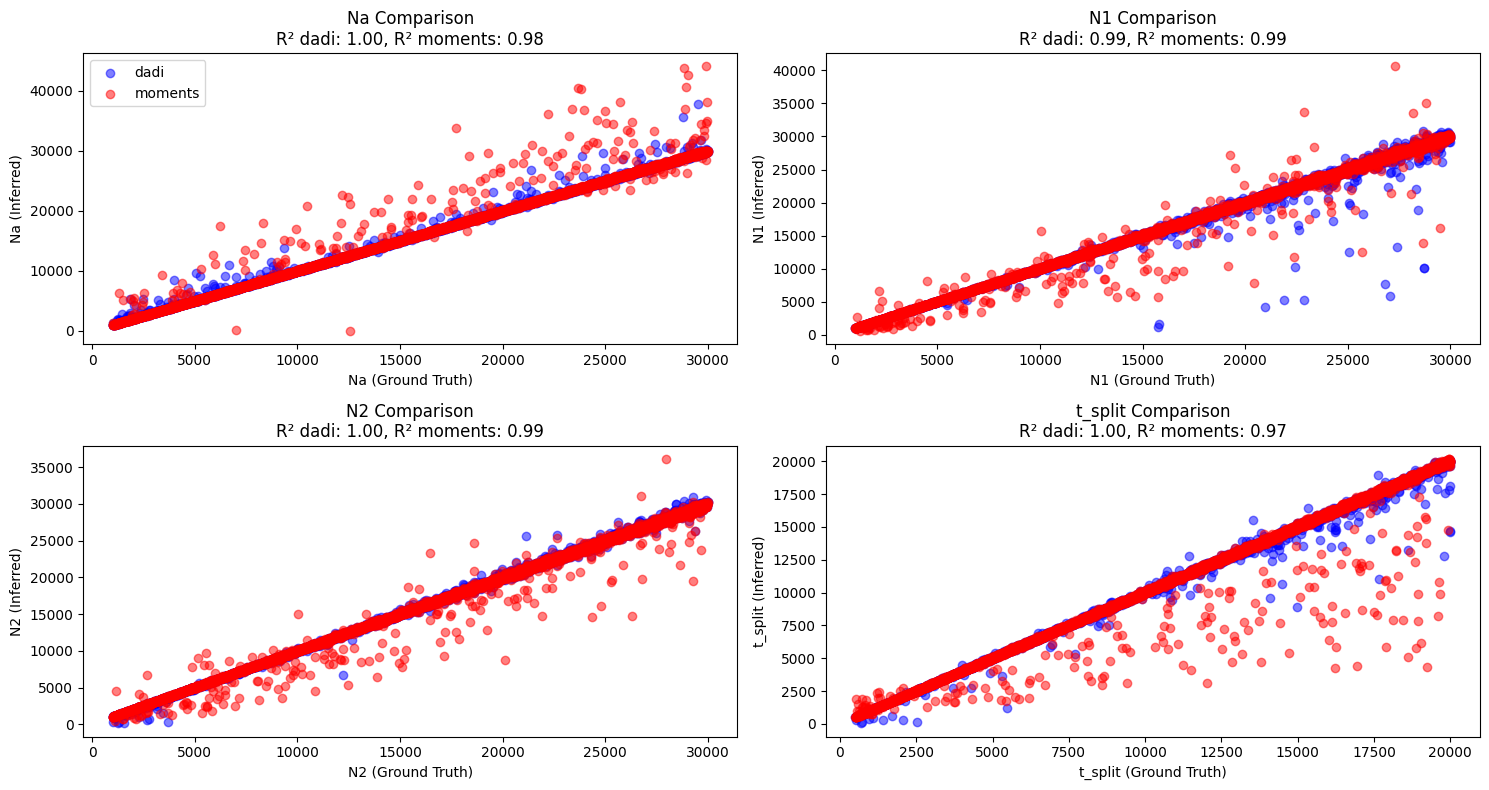

In [33]:
# Create scatterplots with R^2 in titles
fig, axes = plt.subplots(nrows=2, ncols=(len(parameters) + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, param in enumerate(parameters):
    ax = axes[i]

    # Calculate R^2 for dadi
    r2_dadi = np.corrcoef(sim_truths[param], dadi_avgs[param])[0, 1] ** 2

    # Calculate R^2 for moments
    r2_moments = np.corrcoef(sim_truths[param], moments_avgs[param])[0, 1] ** 2

    # Scatterplot
    ax.scatter(sim_truths[param], dadi_avgs[param], color='blue', alpha=0.5, label='dadi')
    ax.scatter(sim_truths[param], moments_avgs[param], color='red', alpha=0.5, label='moments')
    ax.set_xlabel(f"{param} (Ground Truth)")
    ax.set_ylabel(f"{param} (Inferred)")
    ax.set_title(f"{param} Comparison\nR² dadi: {r2_dadi:.2f}, R² moments: {r2_moments:.2f}")
    if i == 0:
        ax.legend()  # Add legend to the first plot

# Hide extra subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [34]:
import numpy as np

ground_truth = sim_truths['Na']      # Ground truth values
dadi_estimates = dadi_avgs['Na']     # Dadi-inferred values
moments_estimates = moments_avgs['Na'] # Moments-inferred values

# Compute MAPE for dadi vs. ground truth
# Make sure ground_truth has no zero values to avoid division by zero.
mape_dadi = np.mean(np.abs((ground_truth - dadi_estimates) / ground_truth)) * 100

# Compute MAPE for moments vs. ground truth
mape_moments = np.mean(np.abs((ground_truth - moments_estimates) / ground_truth)) * 100

print("MAPE (dadi vs ground truth):", mape_dadi, "%")
print("MAPE (moments vs ground truth):", mape_moments, "%")


MAPE (dadi vs ground truth): 1.2493798951271677 %
MAPE (moments vs ground truth): 1.9914387453258096 %


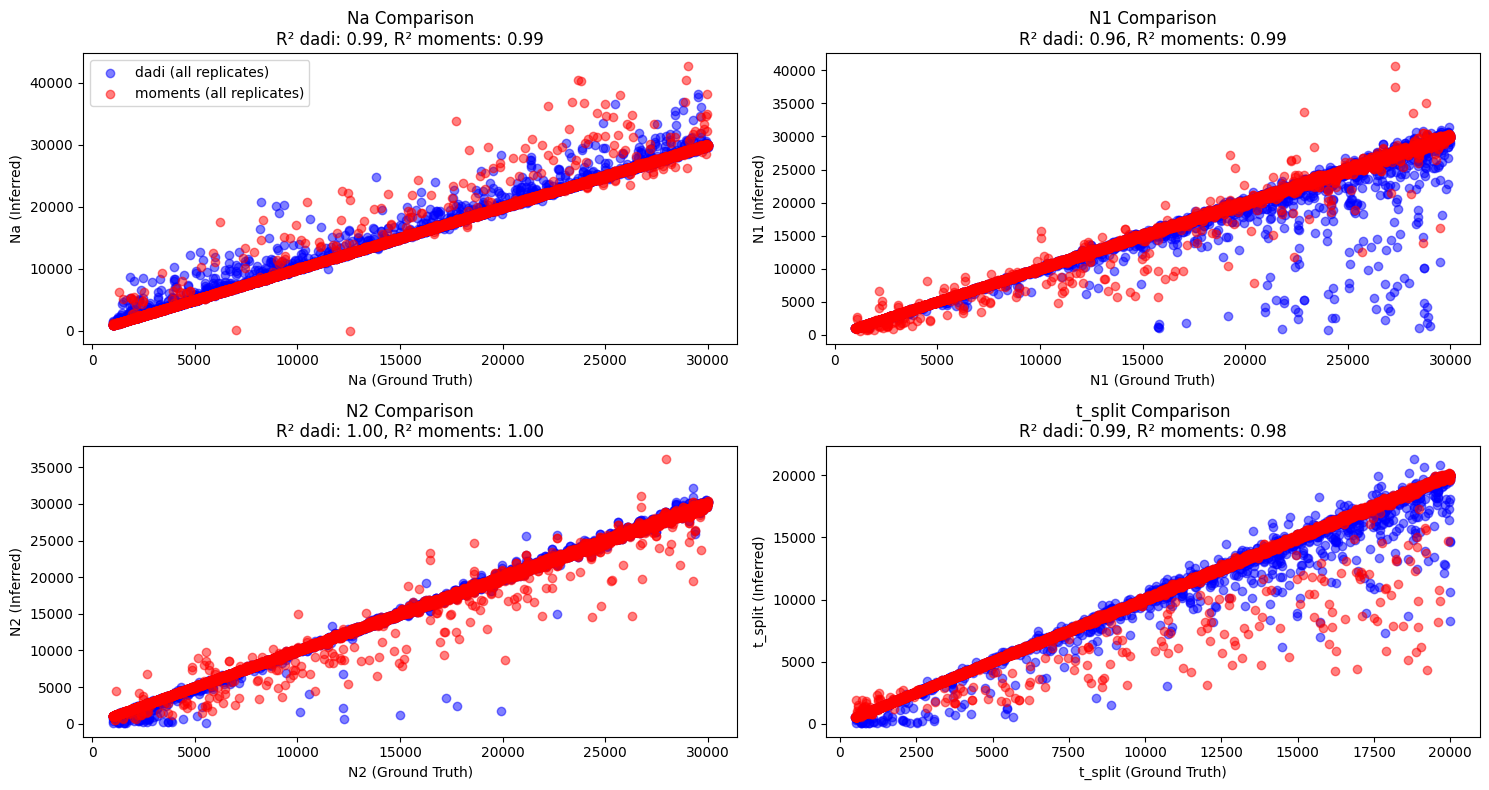

In [36]:
import os
import glob
import pickle
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore

directory = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
file_pattern = os.path.join(directory, "software_inferences_sim_*.pkl")

# Parameters to analyze (excluding "m")
parameters = ["Na", "N1", "N2", "t_split"]

def process_file(filepath):
    # Worker function: Load file and extract replicates for dadi and moments
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    dadi_results = sim_data['opt_params_dadi']
    moments_results = sim_data['opt_params_moments']
    simulated_params = sim_data['simulated_params']

    # Return all replicates along with the ground truth
    dadi_replicates = [rep for rep in dadi_results]  # Keep all dadi replicates
    moments_replicates = [rep for rep in moments_results]  # Keep all moments replicates

    return filepath, simulated_params, dadi_replicates, moments_replicates

# Get all files
files = glob.glob(file_pattern)

# Parallel processing
n_proc = 8  # Adjust based on available cores
with multiprocessing.Pool(n_proc) as pool:
    results = pool.map(process_file, files)

# Extract data for plotting
sim_truths = {param: [] for param in parameters}
dadi_replicates = {param: [] for param in parameters}
moments_replicates = {param: [] for param in parameters}

for file_path, sim_params, dadi_results, moments_results in results:
    for param in parameters:
        # Extend data to include all replicates
        sim_truths[param].extend([sim_params[param]] * len(dadi_results))  # Repeat for each replicate
        dadi_replicates[param].extend([rep[param] for rep in dadi_results])
        moments_replicates[param].extend([rep[param] for rep in moments_results])

# Convert lists to numpy arrays
for param in parameters:
    sim_truths[param] = np.array(sim_truths[param])
    dadi_replicates[param] = np.array(dadi_replicates[param])
    moments_replicates[param] = np.array(moments_replicates[param])

    # Outlier detection for moments replicates
    q1 = np.percentile(moments_replicates[param], 25)
    q3 = np.percentile(moments_replicates[param], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = (moments_replicates[param] >= lower_bound) & (moments_replicates[param] <= upper_bound)

    # Apply mask
    sim_truths[param] = sim_truths[param][mask]
    dadi_replicates[param] = dadi_replicates[param][mask]
    moments_replicates[param] = moments_replicates[param][mask]

# Plot all replicates for dadi and moments
fig, axes = plt.subplots(nrows=2, ncols=(len(parameters) + 1) // 2, figsize=(15, 8))
axes = axes.flatten()

for i, param in enumerate(parameters):
    ax = axes[i]

    # Calculate R^2 for dadi replicates
    r2_dadi = np.corrcoef(sim_truths[param], dadi_replicates[param])[0, 1] ** 2

    # Calculate R^2 for moments replicates
    r2_moments = np.corrcoef(sim_truths[param], moments_replicates[param])[0, 1] ** 2

    # Scatterplot with all replicates
    ax.scatter(sim_truths[param], dadi_replicates[param], color='blue', alpha=0.5, label='dadi (all replicates)')
    ax.scatter(sim_truths[param], moments_replicates[param], color='red', alpha=0.5, label='moments (all replicates)')
    ax.set_xlabel(f"{param} (Ground Truth)")
    ax.set_ylabel(f"{param} (Inferred)")
    ax.set_title(f"{param} Comparison\nR² dadi: {r2_dadi:.2f}, R² moments: {r2_moments:.2f}")
    if i == 0:
        ax.legend()  # Add legend to the first plot

# Hide extra subplots if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [2]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/postprocessing_dict.pkl', 'rb') as f:
    postprocessing_results = pickle.load(f)

In [93]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/preprocessing_results_obj.pkl', 'rb') as f:
    preprocessing_results_obj = pickle.load(f)

In [94]:
preprocessing_results_obj.keys()

dict_keys(['training', 'validation', 'parameter_names'])

In [66]:
preprocessing_results_obj['training']['predictions'].columns

Index(['Moments_rep1_Na', 'Moments_rep1_N1', 'Moments_rep1_N2',
       'Moments_rep1_t_split', 'Moments_rep1_m', 'Moments_rep1_ll',
       'Moments_rep1_FIM_element_0', 'Moments_rep1_FIM_element_1',
       'Moments_rep1_FIM_element_2', 'Moments_rep1_FIM_element_3',
       'Moments_rep1_FIM_element_4', 'Moments_rep1_FIM_element_5',
       'Moments_rep1_FIM_element_6', 'Moments_rep1_FIM_element_7',
       'Moments_rep1_FIM_element_8', 'Moments_rep1_FIM_element_9',
       'Moments_rep2_Na', 'Moments_rep2_N1', 'Moments_rep2_N2',
       'Moments_rep2_t_split', 'Moments_rep2_m', 'Moments_rep2_ll',
       'Moments_rep2_FIM_element_0', 'Moments_rep2_FIM_element_1',
       'Moments_rep2_FIM_element_2', 'Moments_rep2_FIM_element_3',
       'Moments_rep2_FIM_element_4', 'Moments_rep2_FIM_element_5',
       'Moments_rep2_FIM_element_6', 'Moments_rep2_FIM_element_7',
       'Moments_rep2_FIM_element_8', 'Moments_rep2_FIM_element_9',
       'Dadi_rep1_Na', 'Dadi_rep1_N1', 'Dadi_rep1_N2', 'Dadi_rep1_

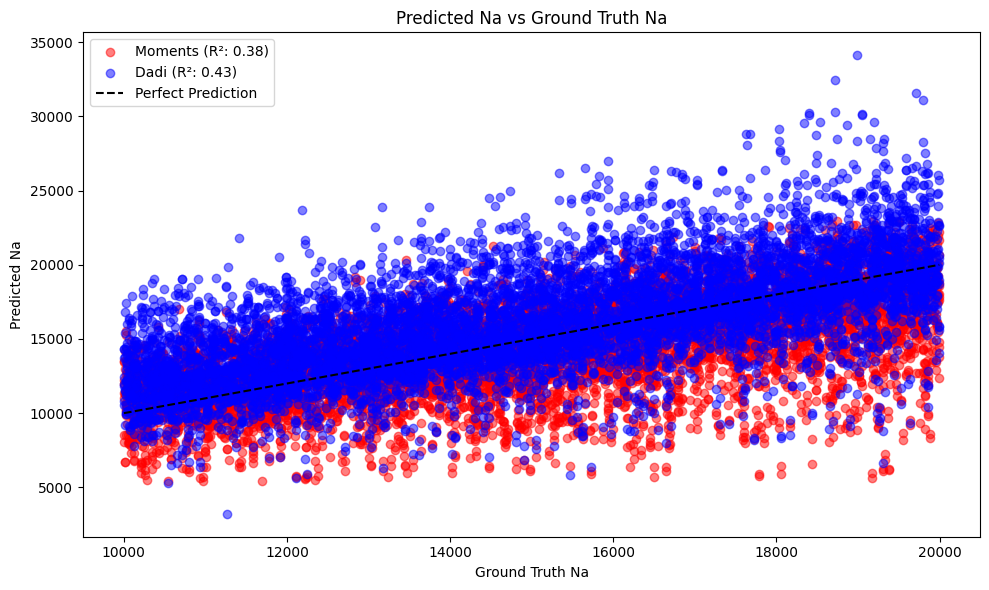

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Extract targets (ground truth Na values)
ground_truth_Na = preprocessing_results_obj['training']['targets']['simulated_params_Na']

# Extract predictions for Moments and Dadi
moments_Na_rep1 = preprocessing_results_obj['training']['predictions']['Moments_rep1_Na']
moments_Na_rep2 = preprocessing_results_obj['training']['predictions']['Moments_rep2_Na']
dadi_Na_rep1 = preprocessing_results_obj['training']['predictions']['Dadi_rep1_Na']
dadi_Na_rep2 = preprocessing_results_obj['training']['predictions']['Dadi_rep2_Na']

# Concatenate predictions for Moments and Dadi
moments_Na = np.concatenate([moments_Na_rep1, moments_Na_rep2])
dadi_Na = np.concatenate([dadi_Na_rep1, dadi_Na_rep2])

# Repeat ground truth Na values for each replicate (assuming two replicates)
ground_truth_Na_replicated = np.concatenate([ground_truth_Na, ground_truth_Na])

# Outlier detection for Moments
q1 = np.percentile(moments_Na, 25)
q3 = np.percentile(moments_Na, 75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
mask_moments = (moments_Na >= lower_bound) & (moments_Na <= upper_bound)

# Filter Moments predictions and corresponding ground truth values
filtered_moments_Na = moments_Na[mask_moments]
filtered_ground_truth_Na_for_moments = ground_truth_Na_replicated[mask_moments]

# Calculate R² for Moments and Dadi
r2_moments = np.corrcoef(filtered_ground_truth_Na_for_moments, filtered_moments_Na)[0, 1] ** 2
r2_dadi = np.corrcoef(ground_truth_Na_replicated, dadi_Na)[0, 1] ** 2

# Plotting
plt.figure(figsize=(10, 6))

# Plot filtered Moments predictions
plt.scatter(filtered_ground_truth_Na_for_moments, filtered_moments_Na, color='red', alpha=0.5, label=f'Moments (R²: {r2_moments:.2f})')

# Plot Dadi predictions
plt.scatter(ground_truth_Na_replicated, dadi_Na, color='blue', alpha=0.5, label=f'Dadi (R²: {r2_dadi:.2f})')

# Plot the diagonal line (perfect prediction)
plt.plot([ground_truth_Na.min(), ground_truth_Na.max()], 
         [ground_truth_Na.min(), ground_truth_Na.max()], 
         color='black', linestyle='--', label='Perfect Prediction')

# Add labels, title, and legend
plt.xlabel('Ground Truth Na')
plt.ylabel('Predicted Na')
plt.title('Predicted Na vs Ground Truth Na')
plt.legend()
plt.tight_layout()
plt.show()


## DEBUG: Recreating the Preprocessing object

In [47]:
training_indices = preprocessing_results_obj['training']['indices']
validation_indices = preprocessing_results_obj['validation']['indices']

In [48]:
training_indices

array([2365, 1117, 3924, ...,   41, 1123, 4187])

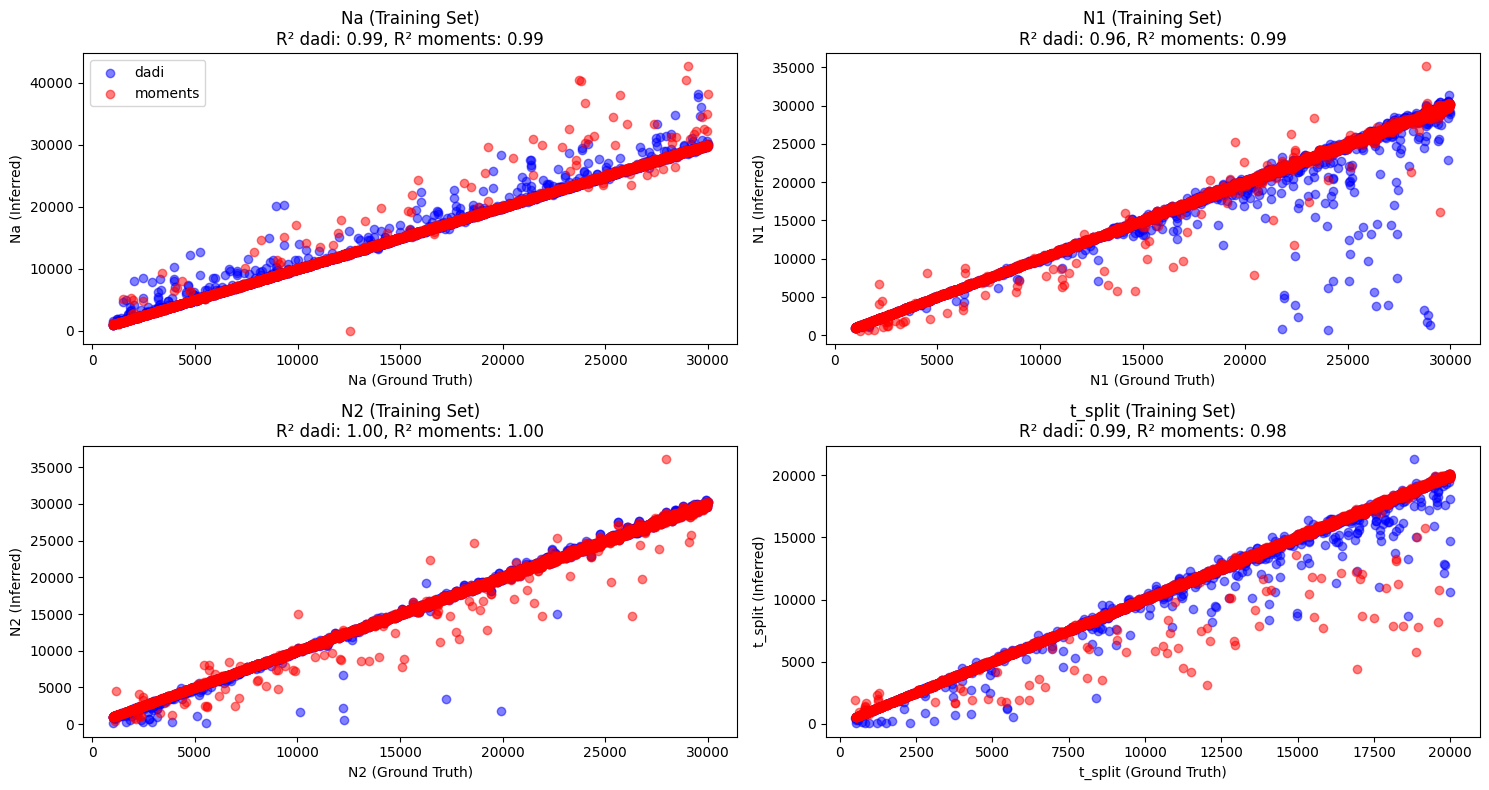

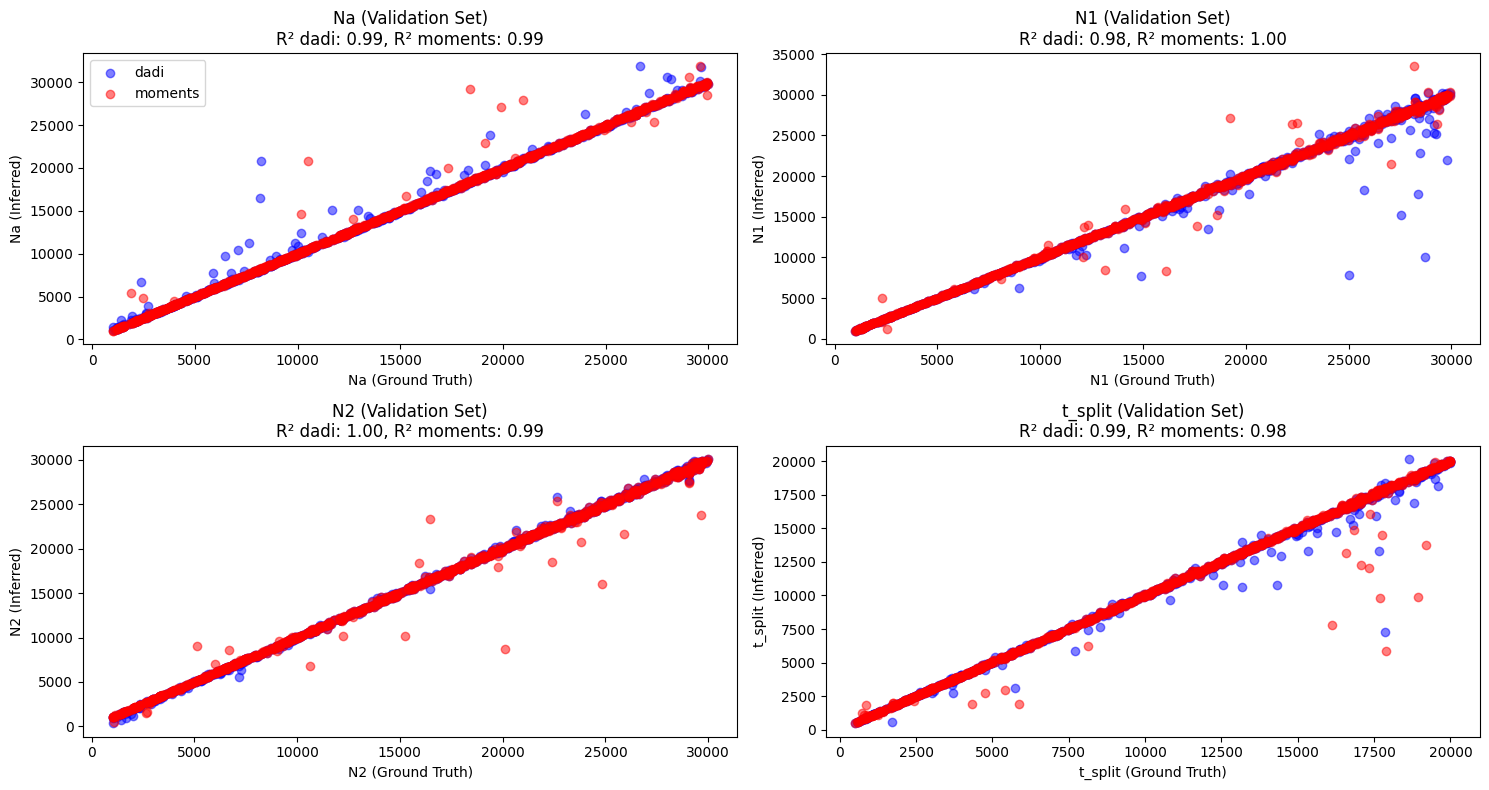

In [49]:
import os
import glob
import pickle
import multiprocessing
import matplotlib.pyplot as plt
import numpy as np

directory = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
file_pattern = os.path.join(directory, "software_inferences_sim_*.pkl")

# Parameters to analyze (excluding "m")
parameters = ["Na", "N1", "N2", "t_split"]

def process_file(filepath):
    # Worker function: Load file and extract replicates for dadi and moments
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    dadi_results = sim_data['opt_params_dadi']
    moments_results = sim_data['opt_params_moments']
    simulated_params = sim_data['simulated_params']

    # Return all replicates along with the ground truth
    dadi_replicates = [rep for rep in dadi_results]  # Keep all dadi replicates
    moments_replicates = [rep for rep in moments_results]  # Keep all moments replicates

    return filepath, simulated_params, dadi_replicates, moments_replicates

# Get all files
files = glob.glob(file_pattern)

# Parallel processing
n_proc = 8  # Adjust based on available cores
with multiprocessing.Pool(n_proc) as pool:
    results = pool.map(process_file, files)

# Extract data for plotting
sim_truths = {param: [] for param in parameters}
dadi_replicates = {param: [] for param in parameters}
moments_replicates = {param: [] for param in parameters}
file_paths = []

for file_path, sim_params, dadi_results, moments_results in results:
    file_paths.append(file_path)
    for param in parameters:
        # Extend data to include all replicates
        sim_truths[param].extend([sim_params[param]] * len(dadi_results))  # Repeat for each replicate
        dadi_replicates[param].extend([rep[param] for rep in dadi_results])
        moments_replicates[param].extend([rep[param] for rep in moments_results])

# Convert lists to numpy arrays
for param in parameters:
    sim_truths[param] = np.array(sim_truths[param])
    dadi_replicates[param] = np.array(dadi_replicates[param])
    moments_replicates[param] = np.array(moments_replicates[param])

# Load training and validation indices
training_indices = preprocessing_results_obj['training']['indices']
validation_indices = preprocessing_results_obj['validation']['indices']

# Function to plot data for a specific split (training or validation)
def plot_split(indices, split_name):
    fig, axes = plt.subplots(nrows=2, ncols=(len(parameters) + 1) // 2, figsize=(15, 8))
    axes = axes.flatten()

    for i, param in enumerate(parameters):
        ax = axes[i]

        # Filter data by indices
        ground_truth_split = sim_truths[param][indices]
        dadi_split = dadi_replicates[param][indices]
        moments_split = moments_replicates[param][indices]

        # Outlier detection for moments
        q1 = np.percentile(moments_split, 25)
        q3 = np.percentile(moments_split, 75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        mask = (moments_split >= lower_bound) & (moments_split <= upper_bound)

        # Apply mask
        ground_truth_split = ground_truth_split[mask]
        dadi_split = dadi_split[mask]
        moments_split = moments_split[mask]

        # Calculate R² for dadi and moments
        r2_dadi = np.corrcoef(ground_truth_split, dadi_split)[0, 1] ** 2
        r2_moments = np.corrcoef(ground_truth_split, moments_split)[0, 1] ** 2

        # Scatterplot
        ax.scatter(ground_truth_split, dadi_split, color='blue', alpha=0.5, label='dadi')
        ax.scatter(ground_truth_split, moments_split, color='red', alpha=0.5, label='moments')
        ax.set_xlabel(f"{param} (Ground Truth)")
        ax.set_ylabel(f"{param} (Inferred)")
        ax.set_title(f"{param} ({split_name} Set)\nR² dadi: {r2_dadi:.2f}, R² moments: {r2_moments:.2f}")
        if i == 0:
            ax.legend()  # Add legend to the first plot

    # Hide extra subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Plot training and validation splits
plot_split(training_indices, "Training")
plot_split(validation_indices, "Validation")


In [50]:
# Set a random seed for reproducibility
np.random.seed(295)
experiment_config_file = '/sietch_colab/akapoor/Demographic_Inference/experiment_config.json'

# Load the experiment configuration
with open(experiment_config_file, "r") as f:
    experiment_config = json.load(f)

# Split the data into training and validation sets
all_indices = np.arange(experiment_config["num_sims_pretrain"])
np.random.shuffle(all_indices)
training_indices = all_indices[:int(experiment_config["training_percentage"] * experiment_config["num_sims_pretrain"])]
validation_indices = all_indices[int(experiment_config["training_percentage"] * experiment_config["num_sims_pretrain"]):]

preprocessing_results_obj = {
    stage: {} for stage in ["training", "validation"]
}

In [52]:
directory = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
file_pattern = os.path.join(directory, "software_inferences_sim_*.pkl")

# Get all files
files = glob.glob(file_pattern)

In [58]:
import re
# Sorting files by extracting the numerical part
sorted_files = sorted(files, key=lambda x: int(re.search(r'software_inferences_sim_(\d+)\.pkl', x).group(1)))


In [59]:
sorted_files

['/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_0.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_1.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_2.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_3.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_4.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_5.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_6.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_7.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_8.pkl',
 '/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inf

In [69]:
with open('/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir/software_inferences_sim_996.pkl', 'rb') as f:
    sim_data = pickle.load(f)

In [70]:
sim_data.keys()

dict_keys(['simulated_params', 'sfs', 'model_sfs_dadi', 'opt_theta_dadi', 'opt_params_dadi', 'll_all_replicates_dadi', 'model_sfs_moments', 'opt_theta_moments', 'opt_params_moments', 'll_all_replicates_moments'])

In [72]:
sim_data['opt_params_moments']

[{'Na': 23433.80353947588,
  'N1': 3664.2300522174246,
  'N2': 15740.530672699097,
  't_split': 17579.749087193286,
  'm': 3.9655559900104707,
  'upper_triangular_FIM': array([-1.19224243e+07, -2.41629583e+05,  3.68787348e+06,  3.51964516e+07,
         -9.88740839e+05,  7.36515656e+05,  4.09668194e+06, -2.03878328e+06,
          2.20084874e+07,  1.30088084e+11]),
  'll': 5840.556024764479},
 {'Na': 23437.70004058061,
  'N1': 3662.6963575160325,
  'N2': 15739.991396768792,
  't_split': 17573.15438165398,
  'm': 4.9904982038856325,
  'upper_triangular_FIM': array([-1.16694317e+07, -2.52912076e+05,  3.70395234e+06,  4.19832981e+07,
         -9.78812426e+05,  7.37987141e+05, -9.76951442e+06, -2.02773913e+06,
          5.83359783e+06,  2.46503762e+11]),
  'll': 5840.550603205847}]

In [102]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
from sklearn.model_selection import train_test_split

with open(experiment_config_file, "r") as f:
    experiment_config = json.load(f)

# Directory containing the simulation data
directory = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
file_pattern = os.path.join(directory, "software_inferences_sim_*.pkl")

# Get and sort all files numerically
files = sorted(glob.glob(file_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Parameters to extract
parameters = ["Na", "N1", "N2", "t_split"]

# Preprocessing containers
predictions_data = []
targets_data = []

# Process each file and extract relevant data
for idx, filepath in enumerate(files):
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    # Extract the inferred parameters for Dadi and Moments
    dadi_results = sim_data['opt_params_dadi']
    moments_results = sim_data['opt_params_moments']

    # Initialize a row dictionary for the current file
    row = {}

    replicates = experiment_config['top_values_k']

    # Add Dadi replicate results
    for replicate in range(1, replicates + 1):
        for param in parameters:
            row[f"dadi_rep{replicate}_{param}"] = dadi_results[replicate - 1][param]

    # Add Moments replicate results
    for replicate in range(1, replicates + 1):
        for param in parameters:
            row[f"moments_rep{replicate}_{param}"] = moments_results[replicate - 1][param]

        # Add FIM elements for Moments
        upper_triangular_FIM = moments_results[replicate - 1].get("upper_triangular_FIM", [])
        for j, value in enumerate(upper_triangular_FIM):
            row[f"moments_rep{replicate}_FIM_element_{j}"] = value

    # Append the row to predictions_data
    predictions_data.append(row)

    # Extract target parameters from simulated_params
    targets_data.append({f"simulated_params_{param}": sim_data['simulated_params'][param] for param in parameters})


# Create a DataFrame from the collected data
predictions_df = pd.DataFrame(predictions_data)
targets_df = pd.DataFrame(targets_data)


In [103]:
targets_df

,simulated_params_Na,simulated_params_N1,simulated_params_N2,simulated_params_t_split
0,24189,24916,14275,17073
1,10486,13164,15270,16109
2,16274,20288,17872,4142
3,15197,28778,15869,6243
4,2470,26576,15646,2689
...,...,...,...,...
4995,17010,26272,11293,7290
4996,4626,16448,11509,9422
4997,3488,28574,18262,3439
4998,12266,3664,16805,8306


In [97]:
sim_data['simulated_params']

{'t_split': 6384, 'N1': 13583, 'N2': 1727, 'Na': 2275, 'm': 0}

In [92]:
preprocessing_results_obj['training']['predictions']

,Moments_rep1_Na,Dadi_rep1_Na,Moments_rep1_N1,Dadi_rep1_N1,Moments_rep1_N2,Dadi_rep1_N2,Moments_rep1_t_split,Dadi_rep1_t_split,Moments_rep2_Na,Dadi_rep2_Na,Moments_rep2_N1,Dadi_rep2_N1,Moments_rep2_N2,Dadi_rep2_N2,Moments_rep2_t_split,Dadi_rep2_t_split
0,12003.916696,11965.115868,16999.550797,17008.850031,19048.020081,19070.258537,6095.644779,6112.469991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25103.136429,25041.417954,27959.360615,28058.860494,21969.366268,21984.852296,4972.581162,4975.533655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1105.608331,1094.983515,23635.790645,24089.324282,17993.501160,18270.645532,3099.363280,3097.551075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3905.523246,3898.412780,2636.260570,2633.500206,9286.820580,9277.236756,5760.602430,5751.631946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,24628.319605,24588.777723,5993.415767,5977.727923,24821.393222,24823.434665,5762.027075,5746.786015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3983,12015.763667,11961.872802,25728.131751,26673.276560,19195.891048,19628.032043,899.066766,908.550795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3984,17937.793634,17892.032431,15399.655171,15383.191686,18176.226622,18184.576903,9003.425711,9011.743172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3985,21477.786921,21434.978917,11672.709576,11602.712421,15710.114069,15740.370349,2684.137535,2703.377357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3986,1735.926727,1677.918621,12586.471702,12609.061733,5241.137659,5245.458343,6799.582797,6836.446470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
preprocessing_results_obj['training'].keys()

dict_keys(['predictions', 'targets', 'indices'])

In [126]:
sim_data

{'simulated_params': {'t_split': 17073,
  'N1': 24916,
  'N2': 14275,
  'Na': 24189,
  'm': 0},
 'opt_params_momentsLD': [{'N1': 24817.86829965041,
   'N2': 14786.819442686994,
   't_split': 17769.284324545784,
   'm': 4.1388841470804657e-07,
   'Na': 24687.924146326848}],
 'll_all_replicates_momentsLD': [170.68354604649494]}

In [3]:
import pandas as pd
import numpy as np
import os
import glob
import pickle
import json
from sklearn.model_selection import train_test_split


experiment_config_file = '/sietch_colab/akapoor/Demographic_Inference/experiment_config.json'

# Load the experiment configuration
with open(experiment_config_file, "r") as f:
    experiment_config = json.load(f)

# Directories containing the simulation data
software_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/software_inferences_dir"
momentsLD_inferences_dir = "/sietch_colab/akapoor/Demographic_Inference/final_LD_inferences"

# File patterns for both types of inferences
software_file_pattern = os.path.join(software_inferences_dir, "software_inferences_sim_*.pkl")
momentsLD_file_pattern = os.path.join(momentsLD_inferences_dir, "momentsLD_inferences_sim_*.pkl")

# Get and sort files numerically
software_files = sorted(glob.glob(software_file_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))
momentsLD_files = sorted(glob.glob(momentsLD_file_pattern), key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Parameters to extract
parameters = ["Na", "N1", "N2", "t_split"]

# Preprocessing containers
software_predictions_data = []  # For dadi and moments
momentsLD_predictions_data = []  # For momentsLD
targets_data = []

# Process software inference files
for idx, filepath in enumerate(software_files):
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    # Extract the inferred parameters for Dadi and Moments
    dadi_results = sim_data['opt_params_dadi']
    moments_results = sim_data['opt_params_moments']

    # Initialize a row dictionary for the current file
    row = {}

    # Number of replicates from experiment configuration
    replicates = experiment_config['top_values_k']

    # Add Dadi replicate results
    for replicate in range(1, replicates + 1):
        for param in parameters:
            row[f"dadi_rep{replicate}_{param}"] = dadi_results[replicate - 1][param]

    # Add Moments replicate results
    for replicate in range(1, replicates + 1):
        for param in parameters:
            row[f"moments_rep{replicate}_{param}"] = moments_results[replicate - 1][param]

    # Append the row to software_predictions_data
    software_predictions_data.append(row)

    # Extract target parameters from simulated_params
    targets_data.append({f"simulated_params_{param}": sim_data['simulated_params'][param] for param in parameters})

# Process momentsLD inference files
for idx, filepath in enumerate(momentsLD_files):
    with open(filepath, 'rb') as f:
        sim_data = pickle.load(f)

    # Initialize a row dictionary for the current momentsLD file
    row = {}

    # Extract inferred parameters from momentsLD
    for param in parameters:
        row[f"momentsLD_{param}"] = sim_data[param]  # Assuming `sim_data` has keys matching `parameters`

    # Append the row to momentsLD_predictions_data
    momentsLD_predictions_data.append(row)

# Create DataFrames for software and momentsLD predictions and targets
software_predictions_df = pd.DataFrame(software_predictions_data)
momentsLD_predictions_df = pd.DataFrame(momentsLD_predictions_data)
targets_df = pd.DataFrame(targets_data)

# Outlier removal for both software and momentsLD predictions
def remove_outliers(df, parameters, prefix):
    """
    Applies outlier removal for a given prefix (e.g., Dadi, Moments, or MomentsLD) and parameters.
    """
    for param in parameters:
        combined_mask = np.ones(len(df), dtype=bool)  # Start with all rows included
        for replicate in range(1, experiment_config['top_values_k'] + 1):
            col = f"{prefix}_rep{replicate}_{param}" if "rep" in prefix else f"{prefix}_{param}"
            if col in df:
                q1 = np.percentile(df[col].dropna(), 25)
                q3 = np.percentile(df[col].dropna(), 75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                mask = (df[col] >= lower_bound) & (df[col] <= upper_bound)
                combined_mask &= mask
        df = df[combined_mask]
    return df.reset_index(drop=True)

# Apply outlier removal to software and momentsLD predictions
filtered_software_predictions_df = remove_outliers(software_predictions_df.copy(), parameters, "moments")
filtered_software_predictions_df = remove_outliers(filtered_software_predictions_df, parameters, "dadi")
filtered_momentsLD_predictions_df = remove_outliers(momentsLD_predictions_df.copy(), parameters, "momentsLD")

# Ensure targets are aligned with filtered software predictions
filtered_targets_df = targets_df.loc[filtered_software_predictions_df.index].reset_index(drop=True)

# Split software predictions into training and validation indices
train_indices, val_indices = train_test_split(range(len(filtered_software_predictions_df)), test_size=0.2, random_state=42)

# Create training and validation subsets
training_predictions = filtered_software_predictions_df.iloc[train_indices].reset_index(drop=True)
validation_predictions = filtered_software_predictions_df.iloc[val_indices].reset_index(drop=True)

training_targets = filtered_targets_df.iloc[train_indices].reset_index(drop=True)
validation_targets = filtered_targets_df.iloc[val_indices].reset_index(drop=True)

# Create preprocessing_results_obj
preprocessing_results_obj = {
    "training": {
        "predictions": training_predictions,
        "targets": training_targets,
        "indices": train_indices,
    },
    "validation": {
        "predictions": validation_predictions,
        "targets": validation_targets,
        "indices": val_indices,
    },
    "parameter_names": parameters,
    "momentsLD_predictions": filtered_momentsLD_predictions_df,  # Include momentsLD predictions
}

# Print the structure of preprocessing_results_obj
print(preprocessing_results_obj.keys())
print(preprocessing_results_obj['training'].keys())
print(preprocessing_results_obj['momentsLD_predictions'].columns)

# Save preprocessing results for debugging (optional)
training_predictions.to_csv("training_predictions.csv", index=False)
validation_predictions.to_csv("validation_predictions.csv", index=False)
training_targets.to_csv("training_targets.csv", index=False)
validation_targets.to_csv("validation_targets.csv", index=False)
filtered_momentsLD_predictions_df.to_csv("momentsLD_predictions.csv", index=False)


KeyError: 'Na'

In [4]:
sim_data

{'simulated_params': {'t_split': 17073,
  'N1': 24916,
  'N2': 14275,
  'Na': 24189,
  'm': 0},
 'opt_params_momentsLD': [{'N1': 24817.86829965041,
   'N2': 14786.819442686994,
   't_split': 17769.284324545784,
   'm': 4.1388841470804657e-07,
   'Na': 24687.924146326848}],
 'll_all_replicates_momentsLD': [170.68354604649494]}

In [5]:
preprocessing_results_obj['training']['predictions']

,dadi_rep1_Na,dadi_rep1_N1,dadi_rep1_N2,dadi_rep1_t_split,dadi_rep2_Na,dadi_rep2_N1,dadi_rep2_N2,dadi_rep2_t_split,moments_rep1_Na,moments_rep1_N1,moments_rep1_N2,moments_rep1_t_split,moments_rep2_Na,moments_rep2_N1,moments_rep2_N2,moments_rep2_t_split,momentsLD_Na,momentsLD_N1,momentsLD_N2,momentsLD_t_split
0,9641.502151,10199.275477,14073.468644,17361.139891,9641.435706,10199.277543,14073.516377,17361.189762,9666.001049,10206.363003,14089.572530,17366.355515,9659.970655,10210.401586,14081.920901,17386.520888,25446.690822,1362.493897,24509.098443,3106.804592
1,21078.029549,12479.068474,22487.509855,5906.926413,21078.294214,12479.029246,22487.876037,5906.286525,21125.081910,12496.808222,22496.151026,5890.326437,21117.810767,12494.674562,22469.962848,5918.661084,NaN,NaN,NaN,NaN
2,2269.164877,17692.678375,27592.657201,2873.662343,2269.169607,17692.623262,27592.667221,2873.662063,2291.265775,17477.396727,27148.807853,2867.589617,2290.721354,17481.442963,27148.193770,2867.689728,12414.790905,17677.300820,24557.341934,15419.245596
3,23341.787959,15042.375170,17875.870587,17089.984047,23341.821967,15042.360801,17875.842038,17089.991135,23382.811375,15068.451678,17873.942304,17131.361156,23386.034824,15058.803844,17890.303584,17101.267960,26126.655572,9369.827081,13809.761414,2217.582682
4,18586.835427,24624.496446,16267.506498,10736.498126,18586.991733,24624.448426,16267.457192,10736.311798,21645.541410,22287.793651,14217.699145,8834.859715,18622.456405,24614.409760,16270.412876,10761.375606,7930.443659,8527.104671,23855.156493,5065.690090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,22033.072844,10345.223301,14250.644638,17236.730022,22032.714728,10345.415376,14250.764354,17236.697715,22073.068215,10356.262011,14262.182820,17256.023904,22071.970809,10355.853022,14265.146344,17245.186868,19402.567245,9180.707663,23089.911729,19650.564413
3996,6169.630586,2732.312555,21173.222778,11997.317545,6169.764446,2732.203037,21173.763905,11996.858301,6173.042685,2741.343416,21196.705710,12026.595302,6170.330873,2741.174858,21201.371129,12027.558145,17580.876345,5647.009806,20423.711925,2931.464047
3997,21254.922040,21210.668460,15957.685637,4150.768096,21254.896224,21210.610960,15957.808852,4150.775808,21303.428032,21179.021531,15979.705659,4139.011148,21307.319928,21186.627224,15963.324893,4137.398988,19676.524365,11281.070305,28924.960365,18310.657327
3998,2325.040167,22607.343965,25129.237123,13880.197670,2333.113941,22745.755675,25164.615084,13807.005866,2277.309332,22593.824012,25139.760328,13934.264562,2278.208433,22589.444464,25145.902174,13932.815774,21653.984295,15771.604072,15130.434535,20299.229562


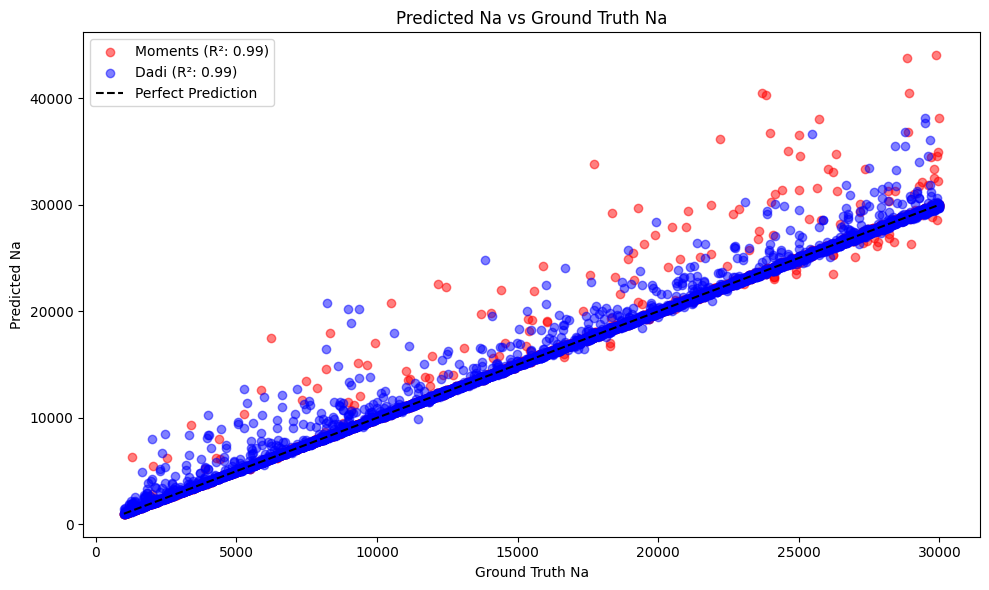

In [ ]:
# Plotting Example for Na
import matplotlib.pyplot as plt

# Extract filtered training data for Na
ground_truth_Na = preprocessing_results_obj['training']['targets']['simulated_params_Na']
moments_Na_rep1 = preprocessing_results_obj['training']['predictions']['moments_rep1_Na']
moments_Na_rep2 = preprocessing_results_obj['training']['predictions']['moments_rep2_Na']
dadi_Na_rep1 = preprocessing_results_obj['training']['predictions']['dadi_rep1_Na']
dadi_Na_rep2 = preprocessing_results_obj['training']['predictions']['dadi_rep2_Na']

# Combine predictions and ground truth for plotting
moments_Na = np.concatenate([moments_Na_rep1, moments_Na_rep2])
dadi_Na = np.concatenate([dadi_Na_rep1, dadi_Na_rep2])
ground_truth_Na_replicated = np.concatenate([ground_truth_Na, ground_truth_Na])

# Calculate R²
r2_moments = np.corrcoef(ground_truth_Na_replicated, moments_Na)[0, 1] ** 2
r2_dadi = np.corrcoef(ground_truth_Na_replicated, dadi_Na)[0, 1] ** 2

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth_Na_replicated, moments_Na, color='red', alpha=0.5, label=f'Moments (R²: {r2_moments:.2f})')
plt.scatter(ground_truth_Na_replicated, dadi_Na, color='blue', alpha=0.5, label=f'Dadi (R²: {r2_dadi:.2f})')
plt.plot([ground_truth_Na.min(), ground_truth_Na.max()],
         [ground_truth_Na.min(), ground_truth_Na.max()],
         color='black', linestyle='--', label='Perfect Prediction')
plt.xlabel('Ground Truth Na')
plt.ylabel('Predicted Na')
plt.title('Predicted Na vs Ground Truth Na')
plt.legend()
plt.tight_layout()
plt.show()

## Postprocessing results

## Plotting results

MSE Values and Standard Errors:
          Moments  Moments_std_err      Dadi  Dadi_std_err  MomentsLD  \
N1       2.254015         0.027179  1.796064      0.023633   0.115280   
N2       1.684775         0.022687  0.856122      0.011961   0.135852   
Na       0.748821         0.012768  0.763167      0.012364   0.271321   
t_split  1.735071         0.022385  1.120917      0.017218   0.143705   

         MomentsLD_std_err  
N1                0.008633  
N2                0.009313  
Na                0.012232  
t_split           0.011141  


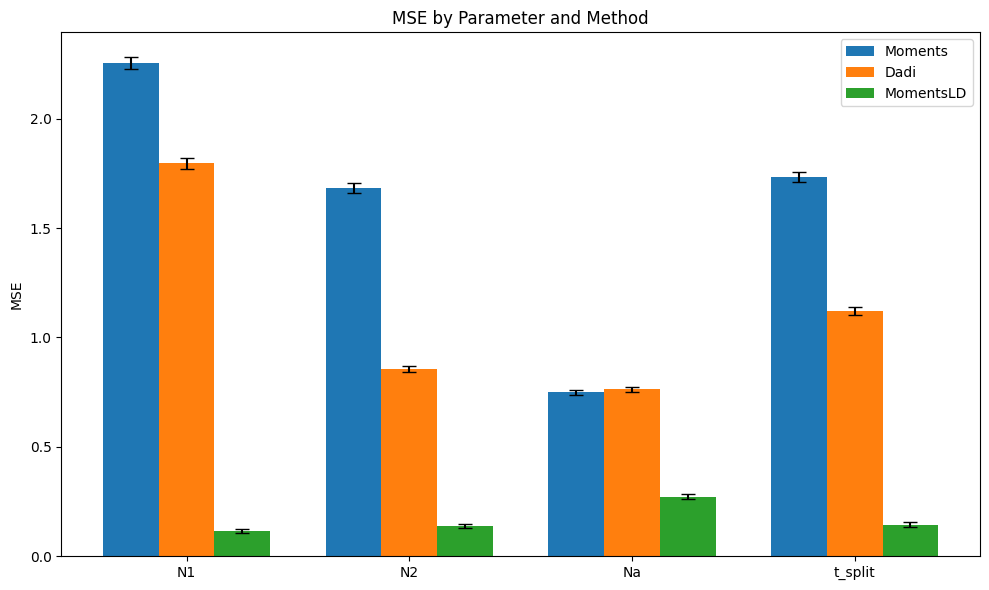

In [14]:
# Calculate MSE and standard errors for each parameter and method
# Calculate MSE and standard errors across simulations
params = ['N1', 'N2', 'Na', 't_split']
methods = ['Moments', 'Dadi', 'MomentsLD']
mse_values = {}
mse_errors = {}

for param in params:
   mse_values[param] = {}
   mse_errors[param] = {}
   target_col = f'simulated_params_{param}'
   target_values = postprocessing_dict['training']['normalized_targets'][target_col]
   
   for method in methods:
       if method == 'Moments':
           # Pool predictions from both replicates
           predictions = np.concatenate([
               postprocessing_dict['training']['normalized_predictions'][f'Moments_rep1_{param}'],
               postprocessing_dict['training']['normalized_predictions'][f'Moments_rep2_{param}']
           ])
           # Repeat targets for both replicates
           targets = np.tile(target_values, 2)
           
       elif method == 'Dadi':
           # Pool predictions from both replicates
           predictions = np.concatenate([
               postprocessing_dict['training']['normalized_predictions'][f'Dadi_rep1_{param}'],
               postprocessing_dict['training']['normalized_predictions'][f'Dadi_rep2_{param}']
           ])
           # Repeat targets for both replicates
           targets = np.tile(target_values, 2)
           
       else:  # MomentsLD
           predictions = postprocessing_dict['training']['normalized_predictions'][f'MomentsLD_{param}']
           targets = target_values

       # Calculate MSE for each simulation
       squared_errors = (predictions - targets) ** 2
       
       # Mean MSE across all simulations
       mse_values[param][method] = np.mean(squared_errors)
       
       # Standard error of MSE across simulations
       mse_errors[param][method] = np.std(squared_errors) / np.sqrt(len(squared_errors))

# Create DataFrame
result_df = pd.DataFrame({
   'Moments': [mse_values[p]['Moments'] for p in params],
   'Moments_std_err': [mse_errors[p]['Moments'] for p in params],
   'Dadi': [mse_values[p]['Dadi'] for p in params],
   'Dadi_std_err': [mse_errors[p]['Dadi'] for p in params],
   'MomentsLD': [mse_values[p]['MomentsLD'] for p in params],
   'MomentsLD_std_err': [mse_errors[p]['MomentsLD'] for p in params]
}, index=params)

print("MSE Values and Standard Errors:")
print(result_df)

# Create grouped bar plot
x = np.arange(len(params))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars with error bars
rects1 = ax.bar(x - width, [mse_values[p]['Moments'] for p in params], width, 
              yerr=[mse_errors[p]['Moments'] for p in params],
              label='Moments', capsize=5)
rects2 = ax.bar(x, [mse_values[p]['Dadi'] for p in params], width,
              yerr=[mse_errors[p]['Dadi'] for p in params],
              label='Dadi', capsize=5)
rects3 = ax.bar(x + width, [mse_values[p]['MomentsLD'] for p in params], width,
              yerr=[mse_errors[p]['MomentsLD'] for p in params],
              label='MomentsLD', capsize=5)

ax.set_ylabel('MSE')
ax.set_title('MSE by Parameter and Method')
ax.set_xticks(x)
ax.set_xticklabels(params)
ax.legend()

plt.tight_layout()
plt.show()

In [15]:
result_df

,Moments,Moments_std_err,Dadi,Dadi_std_err,MomentsLD,MomentsLD_std_err
N1,2.254015,0.027179,1.796064,0.023633,0.115280,0.008633
N2,1.684775,0.022687,0.856122,0.011961,0.135852,0.009313
Na,0.748821,0.012768,0.763167,0.012364,0.271321,0.012232
t_split,1.735071,0.022385,1.120917,0.017218,0.143705,0.011141


In [17]:
result_df.to_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mse_values_preprocess.csv')

In [16]:
np.mean(result_df, axis = 0)

Moments              1.605671
Moments_std_err      0.021255
Dadi                 1.134068
Dadi_std_err         0.016294
MomentsLD            0.166540
MomentsLD_std_err    0.010330
dtype: float64

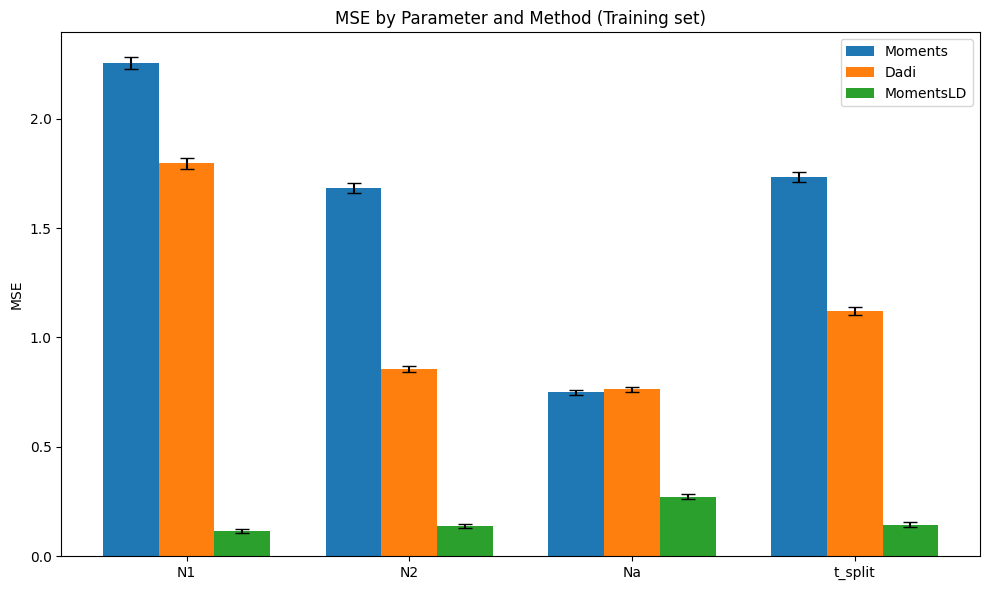

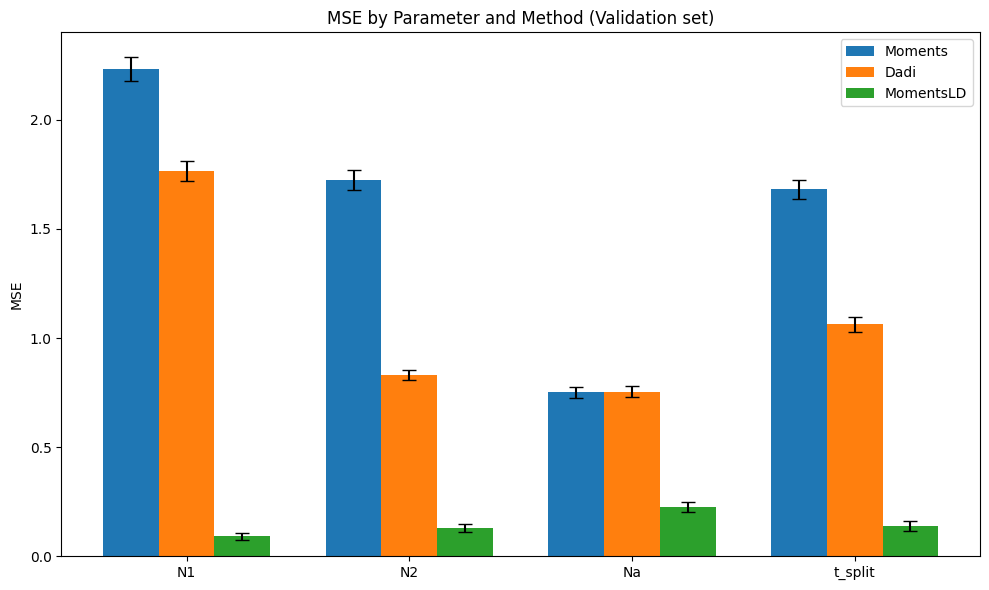

Training MSE Values and Standard Errors:
          Moments  Moments_std_err      Dadi  Dadi_std_err  MomentsLD  \
N1       2.254015         0.027179  1.796064      0.023633   0.115280   
N2       1.684775         0.022687  0.856122      0.011961   0.135852   
Na       0.748821         0.012768  0.763167      0.012364   0.271321   
t_split  1.735071         0.022385  1.120917      0.017218   0.143705   

         MomentsLD_std_err  
N1                0.008633  
N2                0.009313  
Na                0.012232  
t_split           0.011141  

Validation MSE Values and Standard Errors:
          Moments  Moments_std_err      Dadi  Dadi_std_err  MomentsLD  \
N1       2.234071         0.053251  1.766110      0.046791   0.090959   
N2       1.723560         0.045604  0.829150      0.023715   0.130053   
Na       0.752053         0.025191  0.754346      0.025265   0.225992   
t_split  1.682023         0.044007  1.063861      0.034119   0.138893   

         MomentsLD_std_err  
N1       

In [18]:
def calculate_mse_df(dataset_type, postprocessing_dict):
    """Calculate MSE and standard errors for a given dataset type (training or validation)"""
    params = ['N1', 'N2', 'Na', 't_split']
    methods = ['Moments', 'Dadi', 'MomentsLD']
    mse_values = {}
    mse_errors = {}

    for param in params:
        mse_values[param] = {}
        mse_errors[param] = {}
        target_col = f'simulated_params_{param}'
        target_values = postprocessing_dict[dataset_type]['normalized_targets'][target_col]
        
        for method in methods:
            if method in ['Moments', 'Dadi']:
                # Pool predictions from both replicates
                predictions = np.concatenate([
                    postprocessing_dict[dataset_type]['normalized_predictions'][f'{method}_rep1_{param}'],
                    postprocessing_dict[dataset_type]['normalized_predictions'][f'{method}_rep2_{param}']
                ])
                # Repeat targets for both replicates
                targets = np.tile(target_values, 2)
            else:  # MomentsLD
                predictions = postprocessing_dict[dataset_type]['normalized_predictions'][f'MomentsLD_{param}']
                targets = target_values

            # Calculate MSE for each simulation
            squared_errors = (predictions - targets) ** 2
            
            # Mean MSE across all simulations
            mse_values[param][method] = np.mean(squared_errors)
            
            # Standard error of MSE across simulations
            mse_errors[param][method] = np.std(squared_errors) / np.sqrt(len(squared_errors))

    # Create DataFrame
    result_df = pd.DataFrame({
        'Moments': [mse_values[p]['Moments'] for p in params],
        'Moments_std_err': [mse_errors[p]['Moments'] for p in params],
        'Dadi': [mse_values[p]['Dadi'] for p in params],
        'Dadi_std_err': [mse_errors[p]['Dadi'] for p in params],
        'MomentsLD': [mse_values[p]['MomentsLD'] for p in params],
        'MomentsLD_std_err': [mse_errors[p]['MomentsLD'] for p in params]
    }, index=params)
    
    return result_df

def plot_mse_comparison(result_df, dataset_type):
    """Create grouped bar plot for MSE comparison"""
    params = result_df.index
    x = np.arange(len(params))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bars with error bars
    rects1 = ax.bar(x - width, result_df['Moments'], width, 
                  yerr=result_df['Moments_std_err'],
                  label='Moments', capsize=5)
    rects2 = ax.bar(x, result_df['Dadi'], width,
                  yerr=result_df['Dadi_std_err'],
                  label='Dadi', capsize=5)
    rects3 = ax.bar(x + width, result_df['MomentsLD'], width,
                  yerr=result_df['MomentsLD_std_err'],
                  label='MomentsLD', capsize=5)

    ax.set_ylabel('MSE')
    ax.set_title(f'MSE by Parameter and Method ({dataset_type} set)')
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.legend()

    plt.tight_layout()
    return fig

# Calculate MSE for both datasets
train_df = calculate_mse_df('training', postprocessing_dict)
val_df = calculate_mse_df('validation', postprocessing_dict)

# Create plots
train_fig = plot_mse_comparison(train_df, 'Training')
val_fig = plot_mse_comparison(val_df, 'Validation')

# Display plots
plt.show()

# Print DataFrames
print("Training MSE Values and Standard Errors:")
print(train_df)
print("\nValidation MSE Values and Standard Errors:")
print(val_df)

In [19]:
train_df.to_csv("/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_train.csv")
val_df.to_csv("/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_validation.csv")